In [1]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
import pylustrator
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings
import pickle

In [2]:
ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
data = pd.read_csv(Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_audio.csv')))
data['transform'] = data['transform'].replace('fft1216', 'fft')


data.head()

,Unnamed: 0,group,dataset,subset,transform,orientation,channel,dataset_type,obs_var,var_lower,...,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma,github_plot,total_samples.1,beat_all_priors,best_prior,failure_category,failure_type,which_ones
0,0,2,ravdess,1e5geocomp,fft,NaN,female,speech,2.232949e+14,2.044359e+14,...,0.354932,0.000000e+00,0.999723,https://github.com/yashdave003/hierarchical-ba...,2880.0,1,GenGamma,NaN,NaN,NaN
1,1,5,ravdess,1e5geocomp,fft,NaN,female,speech,3.311355e+14,2.838907e+14,...,0.335270,0.000000e+00,0.667167,https://github.com/yashdave003/hierarchical-ba...,8640.0,1,GenGamma,NaN,NaN,NaN
2,2,8,ravdess,1e5geocomp,fft,NaN,female,speech,6.176871e+13,5.192469e+13,...,0.272570,0.000000e+00,0.670672,https://github.com/yashdave003/hierarchical-ba...,24480.0,1,GenGamma,NaN,NaN,NaN
3,3,11,ravdess,1e5geocomp,fft,NaN,female,speech,7.202464e+12,6.829576e+12,...,0.135410,0.000000e+00,0.999552,https://github.com/yashdave003/hierarchical-ba...,67680.0,1,GenGamma,NaN,NaN,NaN
4,4,14,ravdess,1e5geocomp,fft,NaN,female,speech,2.573510e+12,2.321575e+12,...,0.017024,1.483210e-47,0.282882,https://github.com/yashdave003/hierarchical-ba...,187200.0,1,GenGamma,NaN,NaN,NaN


In [3]:
DATASETS = ['ravdess']
GROUPS = {'ravdess': ['female', 'male', 'normal_intensity', 'statement_1', 'statement_2', 'strong_intensity']}
BANDS = {'ravdess': ['geo', 'raw']}
TRANSFORMS = {'ravdess': ['fft', 'erb', 'stft']}

dfs = []

# Directory where pickles are stored. Adjust this as required!
pickle_dir = Path(os.path.join(ROOT_DIR, "transformed-data-audio", "freq-bands"))

for dataset in DATASETS:
    for band in BANDS[dataset]:
        for transform in TRANSFORMS[dataset]:
            for group in GROUPS[dataset]:
                file_name = f"{dataset}-{band}-{transform}-{group}-freq-band.pickle"
                file_path = pickle_dir / file_name
                if file_path.exists():
                    with open(file_path, "rb") as f:
                        d = pickle.load(f)
                    rows = []
                    for band_group, freqs in d.items():
                        rows.append({
                            "band_groups": band_group,
                            "frequencies": freqs,
                            "transform": transform,
                            "dataset": dataset,
                            "group": group,
                            "band": band
                        })
                    df = pd.DataFrame(rows)
                    dfs.append(df)
                else:
                    pass

freq_bands_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(
    columns=["band_groups", "frequencies", "transform", "dataset", "group", "band"]
)

In [4]:
freq_bands_df

,band_groups,frequencies,transform,dataset,group,band
0,0,0,fft,ravdess,female,geo
1,1,1-2,fft,ravdess,female,geo
2,2,3-4,fft,ravdess,female,geo
3,3,5-7,fft,ravdess,female,geo
4,4,8-11,fft,ravdess,female,geo
...,...,...,...,...,...,...
595,5,128-255,stft,ravdess,strong_intensity,raw
596,6,256-319,stft,ravdess,strong_intensity,raw
597,7,320-383,stft,ravdess,strong_intensity,raw
598,8,384-447,stft,ravdess,strong_intensity,raw


In [5]:
def determine_band(subset):
    if isinstance(subset, str):
        if 'raw' in subset:
            return 'raw'
        elif 'geo' in subset:
            return 'geo'
    return None

data['band'] = data['subset'].apply(determine_band)

data_merged = pd.merge(
    data,
    freq_bands_df.rename(columns={'group': 'channel'}),
    how='left',
    left_on=['dataset', 'channel', 'transform', 'band', 'group'],
    right_on=['dataset', 'channel', 'transform', 'band', 'band_groups']
)

data = data_merged.drop(columns = ['band_groups'])

In [6]:
cwt = data[data['transform'] == 'cwt']
fft = data[data['transform'] == 'fft']
stft = data[data['transform'] == 'stft']
erb = data[data['transform'] == 'erb']

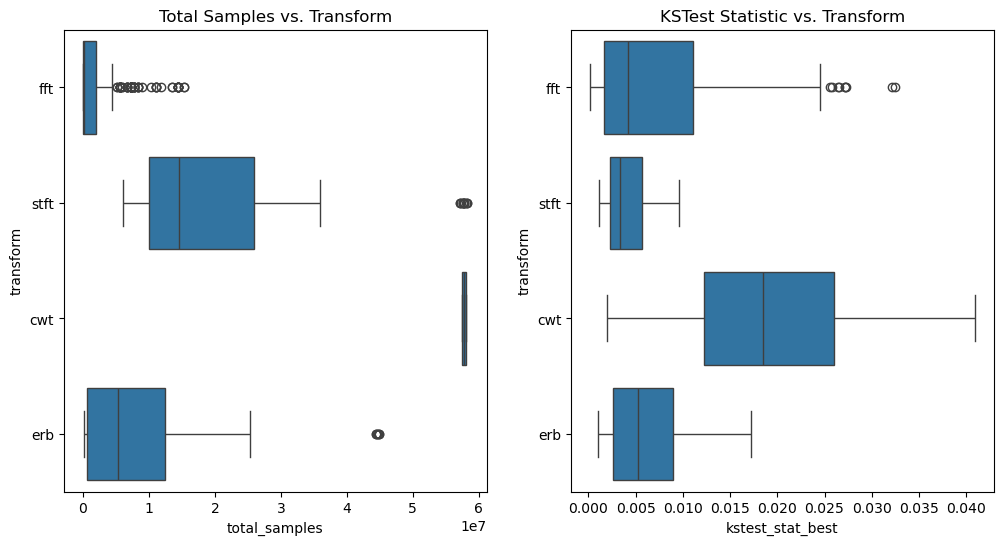

In [7]:
fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))
sns.boxplot(data = data, x = 'total_samples', y = 'transform', ax = axs[0]);
axs[0].set_title('Total Samples vs. Transform');
sns.boxplot(data = data, x = 'kstest_stat_best', y = 'transform', ax = axs[1]);
axs[1].set_title('KSTest Statistic vs. Transform');

C:\Users\Henry\AppData\Local\Temp\ipykernel_30988\2469119290.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[1].set_xlim(0, 1e-175);


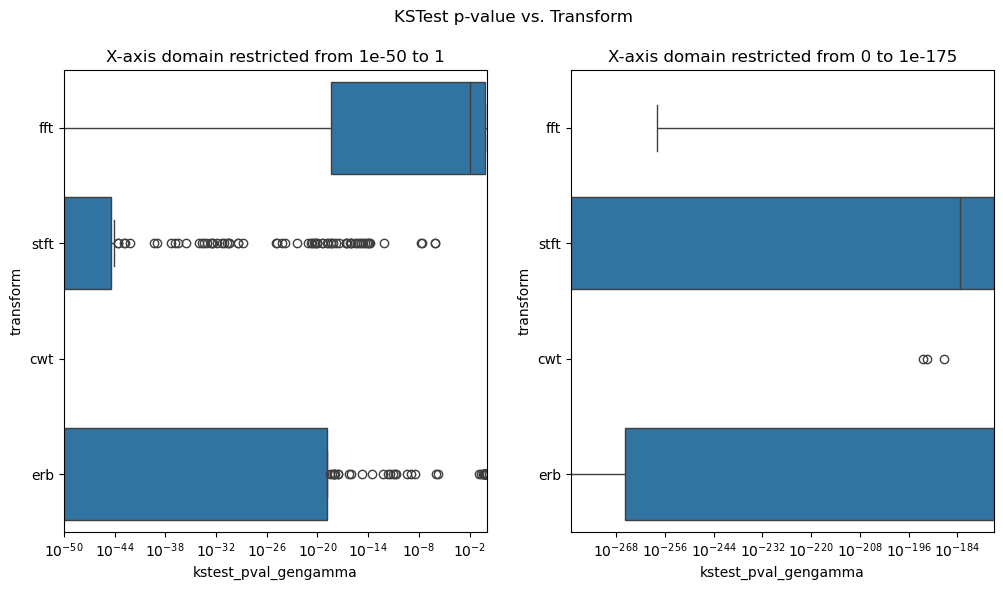

In [8]:
fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))

sns.boxplot(data = data, x = 'kstest_pval_gengamma', y = 'transform', ax = axs[0]);
axs[0].set_xscale('log');
axs[0].set_xlim(1e-50, 1);
axs[0].set_title('X-axis domain restricted from 1e-50 to 1');

sns.boxplot(data = data, x = 'kstest_pval_gengamma', y = 'transform', ax = axs[1]);
axs[1].set_xscale('log');
axs[1].set_xlim(0, 1e-175);
axs[1].set_title('X-axis domain restricted from 0 to 1e-175');

fig.suptitle('KSTest p-value vs. Transform');

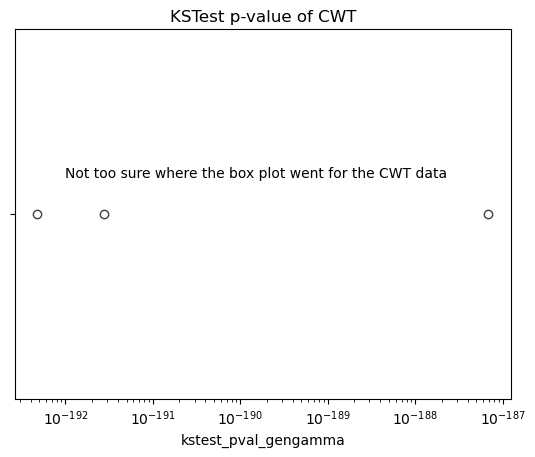

In [9]:
sns.boxplot(data = cwt, x = 'kstest_pval_gengamma');
plt.xscale('log');
plt.text(10 ** -192, -0.1, 'Not too sure where the box plot went for the CWT data')
plt.title('KSTest p-value of CWT');

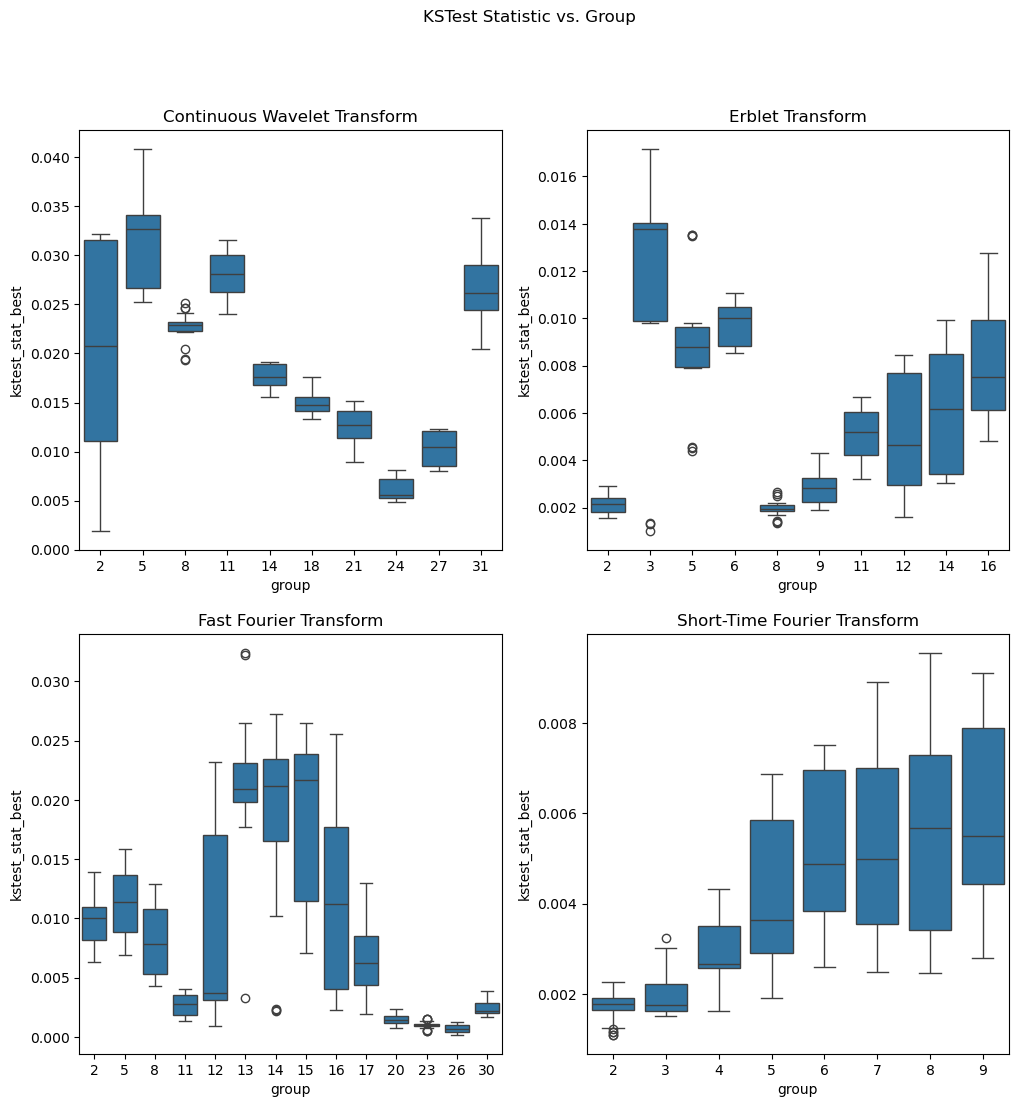

In [10]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 12))
sns.boxplot(data = cwt, x = 'group', y = 'kstest_stat_best', ax = axs[0,0]);
axs[0,0].set_title('Continuous Wavelet Transform');
sns.boxplot(data = erb, x = 'group', y = 'kstest_stat_best', ax = axs[0,1]);
axs[0,1].set_title('Erblet Transform');
sns.boxplot(data = fft, x = 'group', y = 'kstest_stat_best', ax = axs[1,0]);
axs[1,0].set_title('Fast Fourier Transform');
sns.boxplot(data = stft, x = 'group', y = 'kstest_stat_best', ax = axs[1,1]);
axs[1,1].set_title('Short-Time Fourier Transform');

fig.suptitle('KSTest Statistic vs. Group');

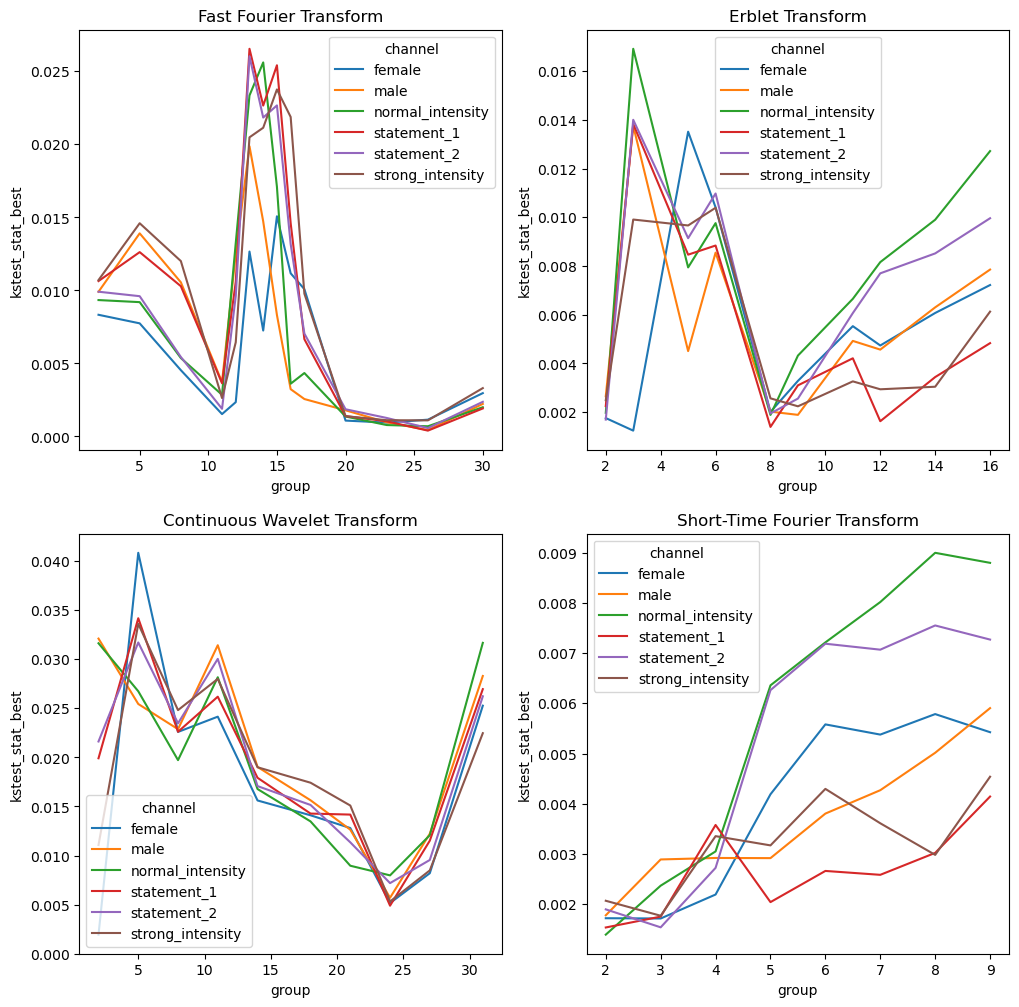

In [11]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 12))

sns.lineplot(data = fft, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[0,0]);
axs[0,0].set_title('Fast Fourier Transform');
sns.lineplot(data = erb, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[0,1]);
axs[0,1].set_title('Erblet Transform');
sns.lineplot(data = cwt, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[1,0]);
axs[1,0].set_title('Continuous Wavelet Transform');
sns.lineplot(data = stft, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[1,1]);
axs[1,1].set_title('Short-Time Fourier Transform');

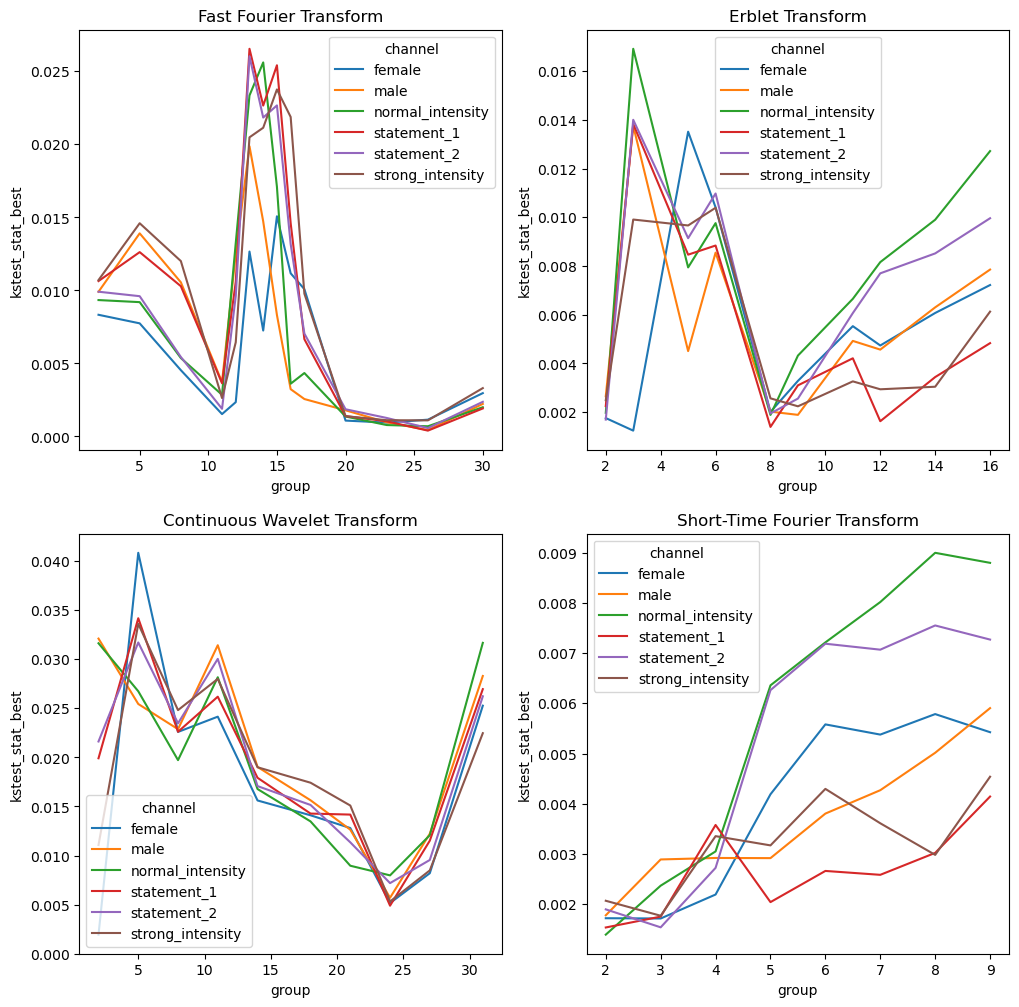

In [12]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 12))

sns.lineplot(data = fft, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[0,0])
axs[0,0].set_title('Fast Fourier Transform')
sns.lineplot(data = erb, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[0,1])
axs[0,1].set_title('Erblet Transform')
sns.lineplot(data = cwt, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[1,0])
axs[1,0].set_title('Continuous Wavelet Transform')
sns.lineplot(data = stft, x = 'group', y = 'kstest_stat_best', hue = 'channel', errorbar = None, ax = axs[1,1])
axs[1,1].set_title('Short-Time Fourier Transform');

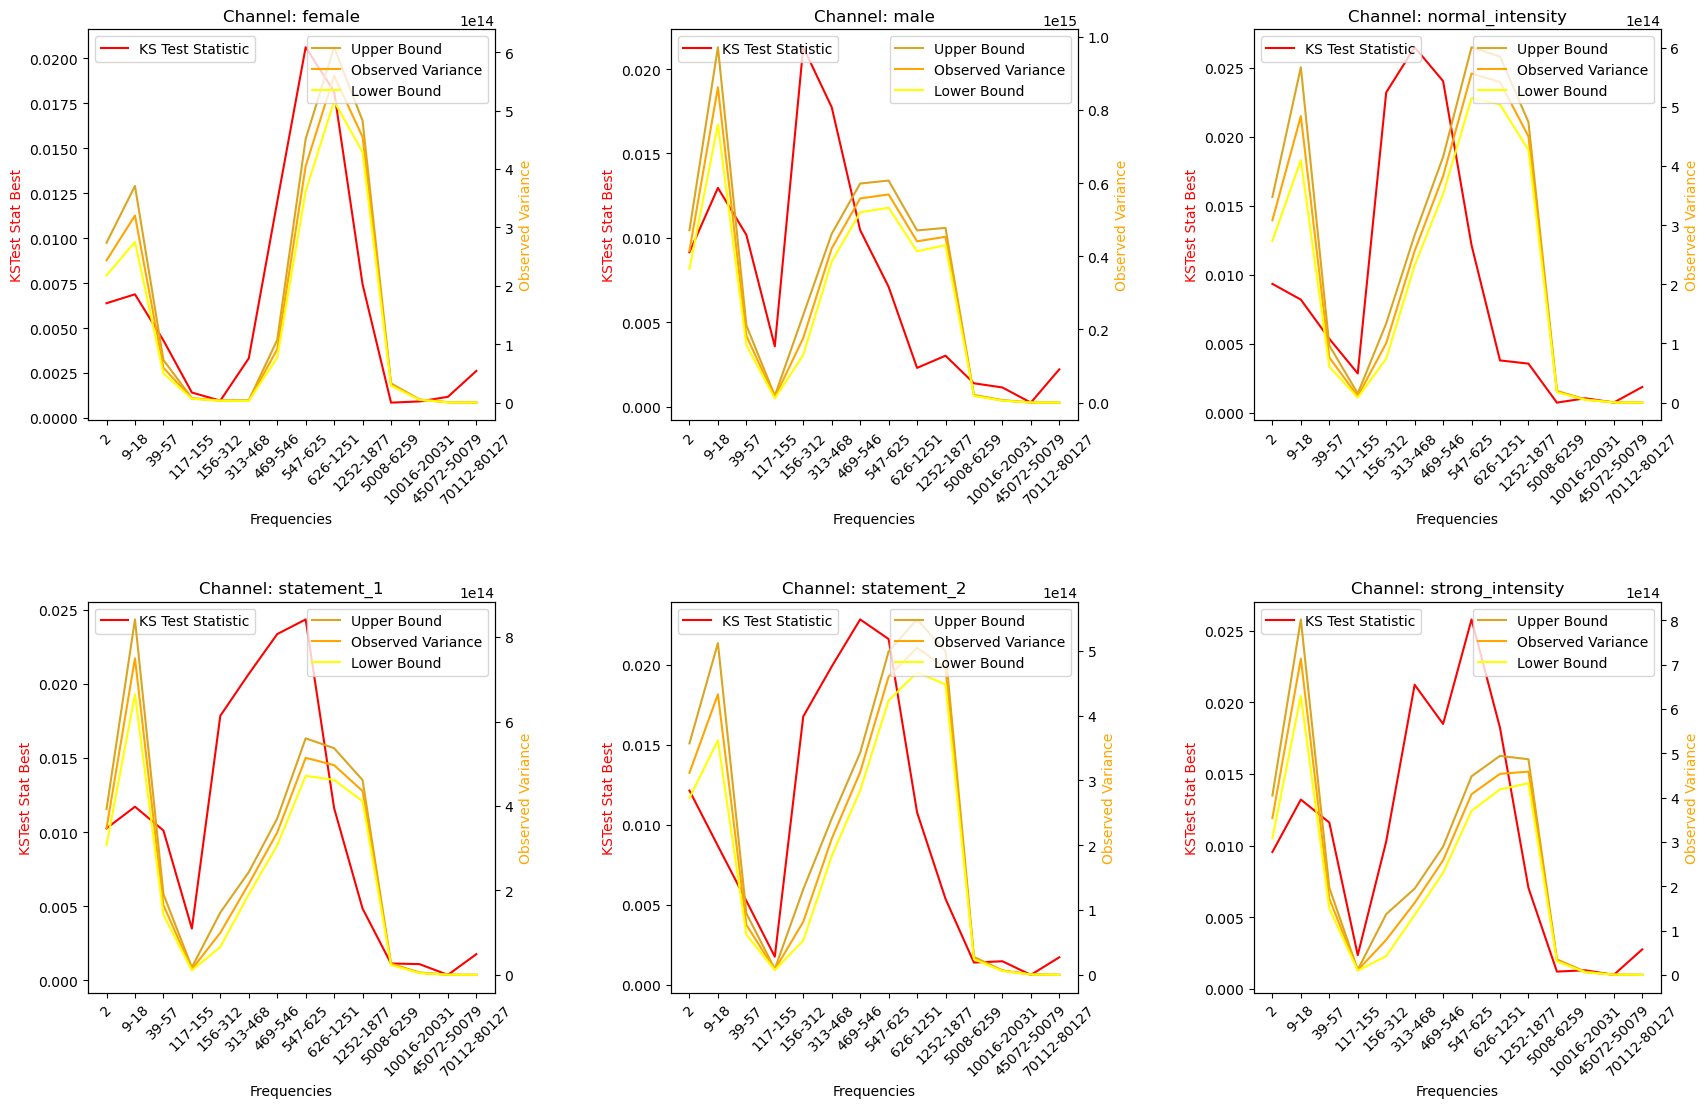

In [71]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18, 12))

fft_rawcomp = fft[fft['subset'] == '1e5rawcomp']
counter = 0
for group in GROUPS['ravdess']:
    subset = fft_rawcomp[fft_rawcomp['channel'] == group]
    freqs = subset['frequencies']
    def sort_key(val):
        part = str(val).split('-')[0]
        try:
            return int(part)
        except ValueError:
            return float('inf')

    sorted_indices = freqs.apply(sort_key).sort_values().index
    axs[counter // 3, counter % 3].plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kstest_stat_best'], label = 'KS Test Statistic', color = 'red')
    axs[counter // 3, counter % 3].set_title(f'Channel: {group}')
    axs[counter // 3, counter % 3].set_xlabel('Frequencies')
    axs[counter // 3, counter % 3].set_ylabel('KSTest Stat Best', color = 'red')
    axs[counter // 3, counter % 3].tick_params(axis = 'x', labelrotation = 45)
    ax2 = axs[counter // 3, counter % 3].twinx()
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'var_upper'], label = 'Upper Bound', color = 'goldenrod')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'obs_var'], label = 'Observed Variance', color = 'orange')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'var_lower'], label = 'Lower Bound', color = 'yellow')
    ax2.set_xlabel('Frequencies')
    ax2.set_ylabel('Observed Variance', color = 'orange')
    ax2.tick_params(axis = 'x', labelrotation = 45)
    ax2.legend(loc = 'upper right')
    axs[counter // 3, counter % 3].legend(loc = 'upper left')
    counter += 1

fig.tight_layout(pad=4.0) 

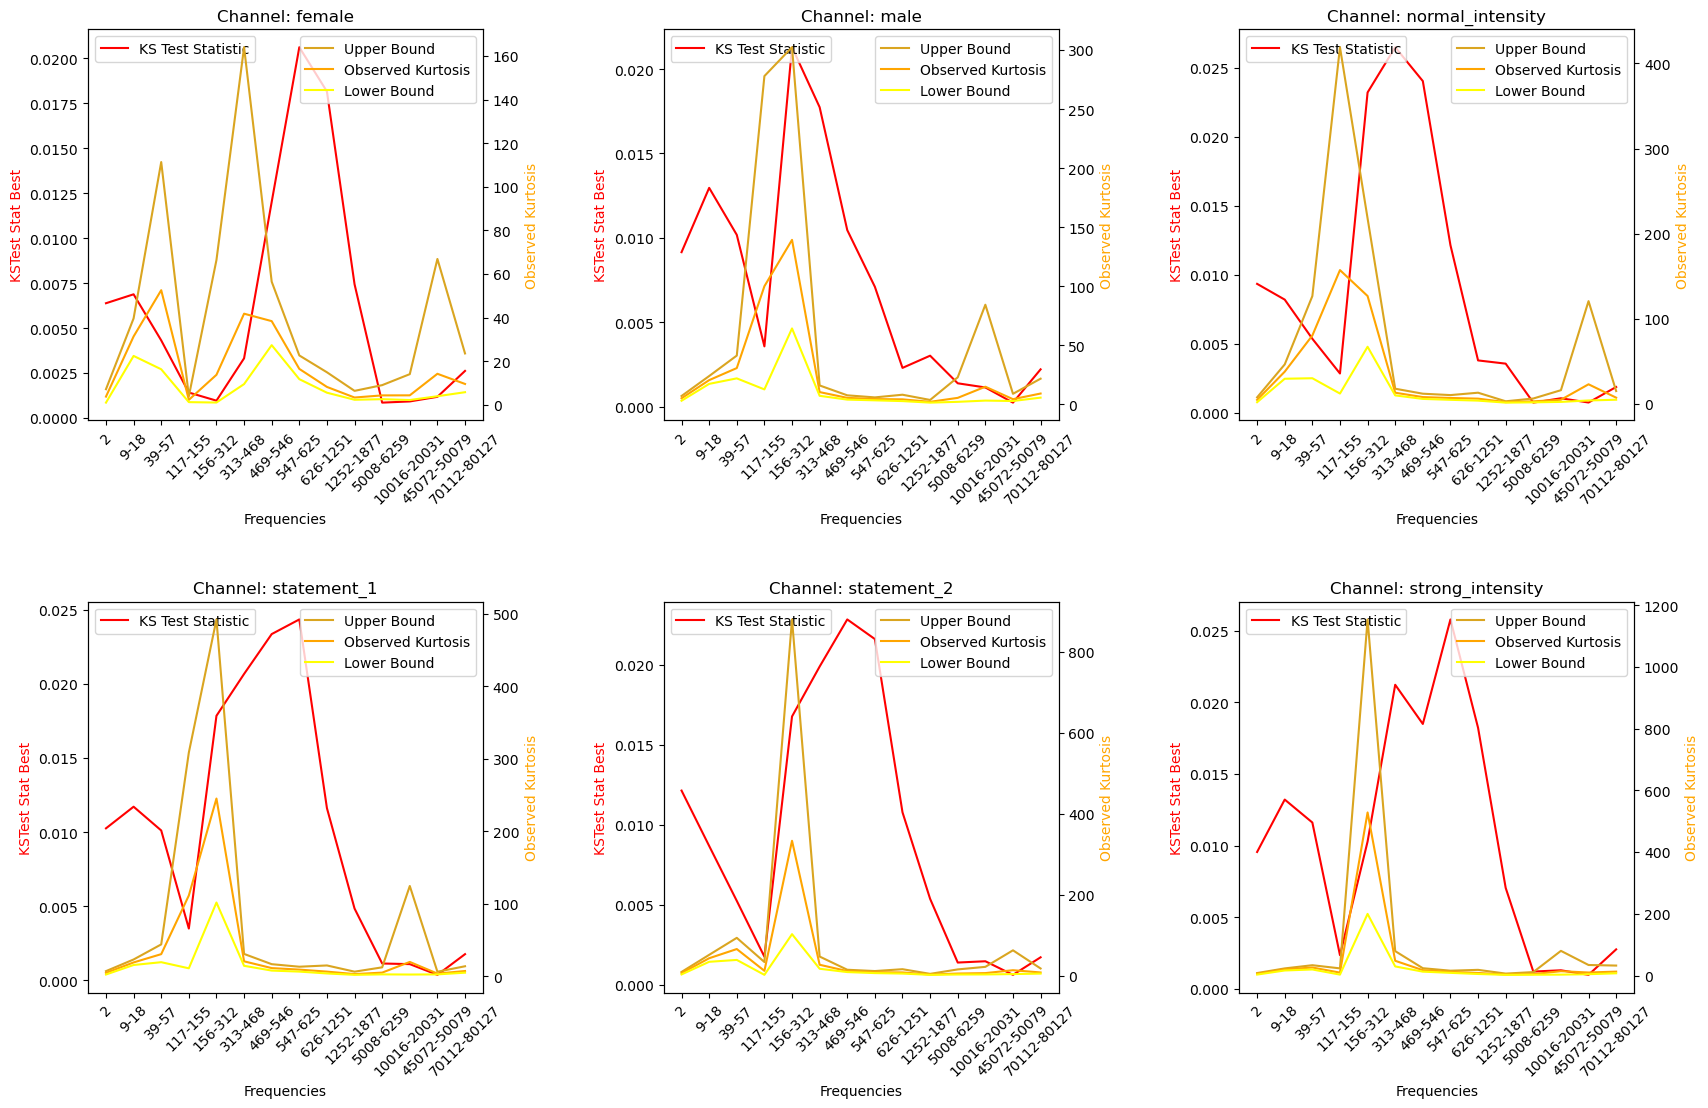

In [72]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18, 12))

fft_rawcomp = fft[fft['subset'] == '1e5rawcomp']
counter = 0
for group in GROUPS['ravdess']:
    subset = fft_rawcomp[fft_rawcomp['channel'] == group]
    freqs = subset['frequencies']
    def sort_key(val):
        part = str(val).split('-')[0]
        try:
            return int(part)
        except ValueError:
            return float('inf')

    sorted_indices = freqs.apply(sort_key).sort_values().index
    axs[counter // 3, counter % 3].plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kstest_stat_best'], label = 'KS Test Statistic', color = 'red')
    axs[counter // 3, counter % 3].set_title(f'Channel: {group}')
    axs[counter // 3, counter % 3].set_xlabel('Frequencies')
    axs[counter // 3, counter % 3].set_ylabel('KSTest Stat Best', color = 'red')
    axs[counter // 3, counter % 3].tick_params(axis = 'x', labelrotation = 45)
    ax2 = axs[counter // 3, counter % 3].twinx()
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kurt_upper'], label = 'Upper Bound', color = 'goldenrod')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'obs_kurt'], label = 'Observed Kurtosis', color = 'orange')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kurt_lower'], label = 'Lower Bound', color = 'yellow')
    ax2.set_xlabel('Frequencies')
    ax2.set_ylabel('Observed Kurtosis', color = 'orange')
    ax2.tick_params(axis = 'x', labelrotation = 45)
    ax2.legend(loc = 'upper right')
    axs[counter // 3, counter % 3].legend(loc = 'upper left')
    counter += 1

fig.tight_layout(pad=4.0) 

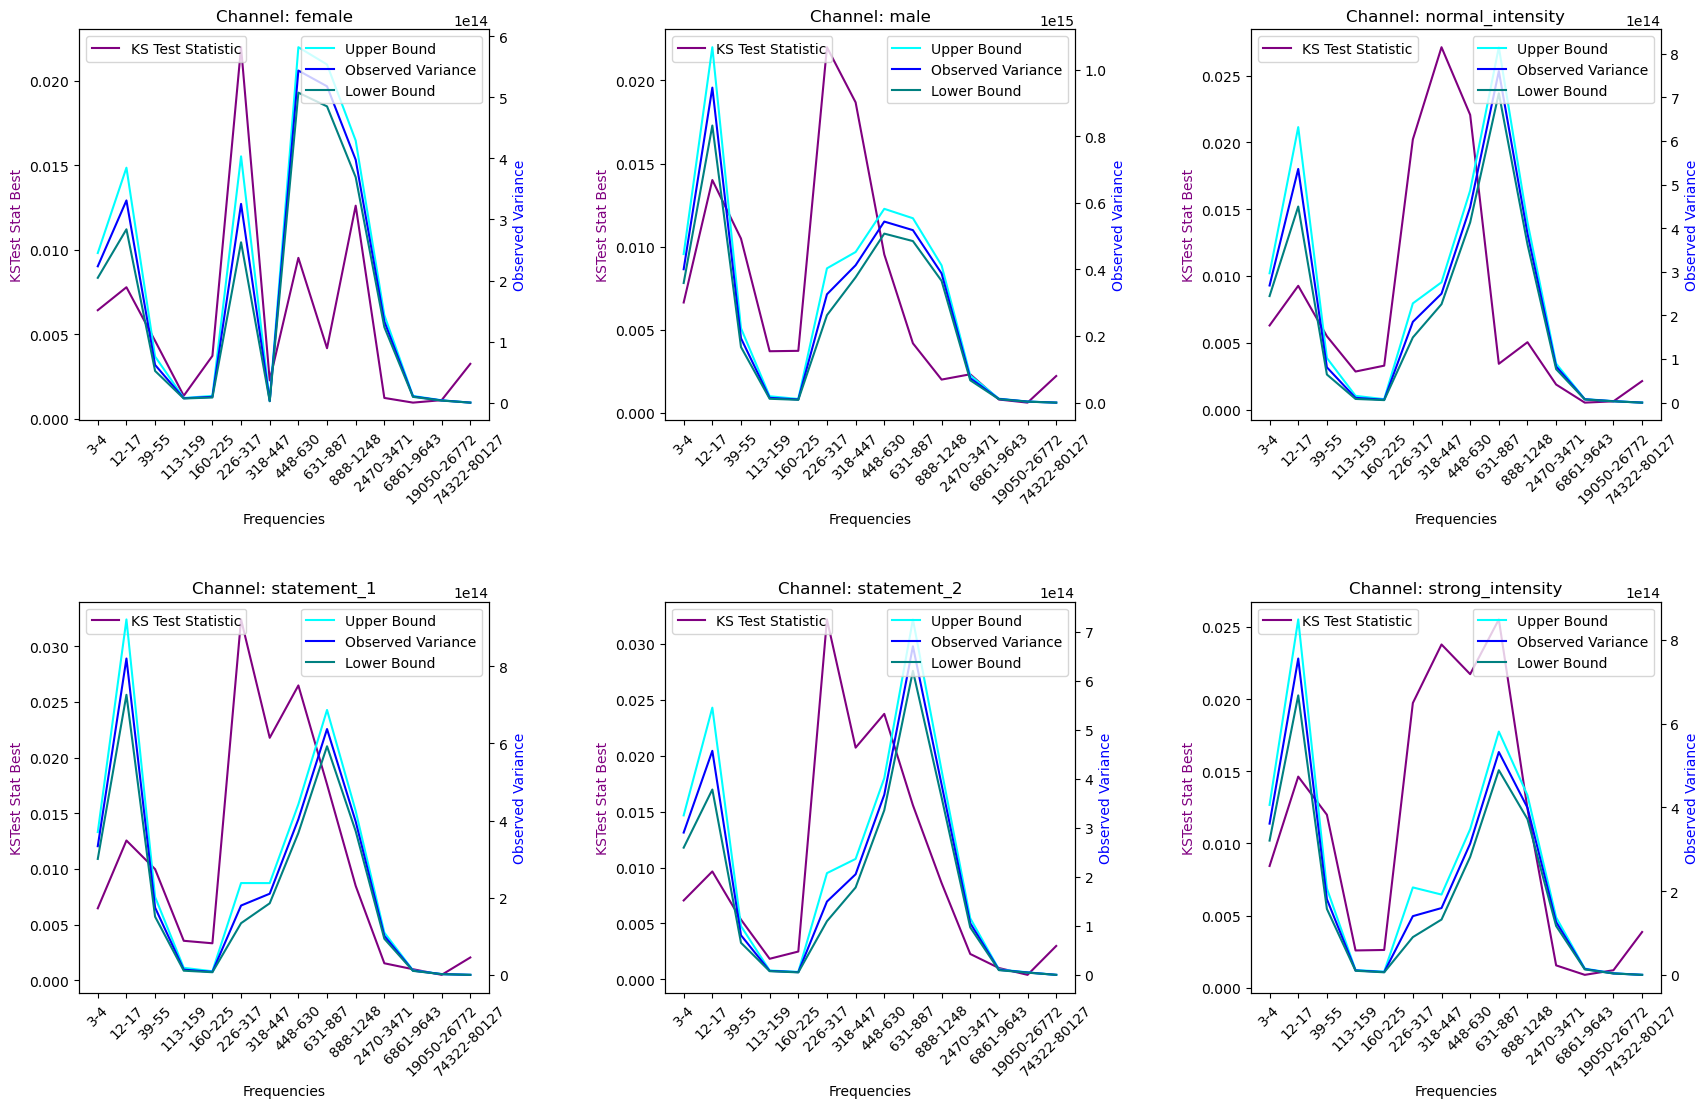

In [69]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18, 12))

fft_geocomp = fft[fft['subset'] == '1e5geocomp']
counter = 0
for group in GROUPS['ravdess']:
    subset = fft_geocomp[fft_geocomp['channel'] == group]
    freqs = subset['frequencies']
    def sort_key(val):
        part = str(val).split('-')[0]
        try:
            return int(part)
        except ValueError:
            return float('inf')

    sorted_indices = freqs.apply(sort_key).sort_values().index
    axs[counter // 3, counter % 3].plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kstest_stat_best'], label = 'KS Test Statistic', color = 'purple')
    axs[counter // 3, counter % 3].set_title(f'Channel: {group}')
    axs[counter // 3, counter % 3].set_xlabel('Frequencies')
    axs[counter // 3, counter % 3].set_ylabel('KSTest Stat Best', color = 'purple')
    axs[counter // 3, counter % 3].tick_params(axis = 'x', labelrotation = 45)
    ax2 = axs[counter // 3, counter % 3].twinx()
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'var_upper'], label = 'Upper Bound', color = 'cyan')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'obs_var'], label = 'Observed Variance', color = 'blue')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'var_lower'], label = 'Lower Bound', color = 'teal')
    ax2.set_xlabel('Frequencies')
    ax2.set_ylabel('Observed Variance', color = 'blue')
    ax2.tick_params(axis = 'x', labelrotation = 45)
    ax2.legend(loc = 'upper right')
    axs[counter // 3, counter % 3].legend(loc = 'upper left')
    counter += 1

fig.tight_layout(pad=4.0) 

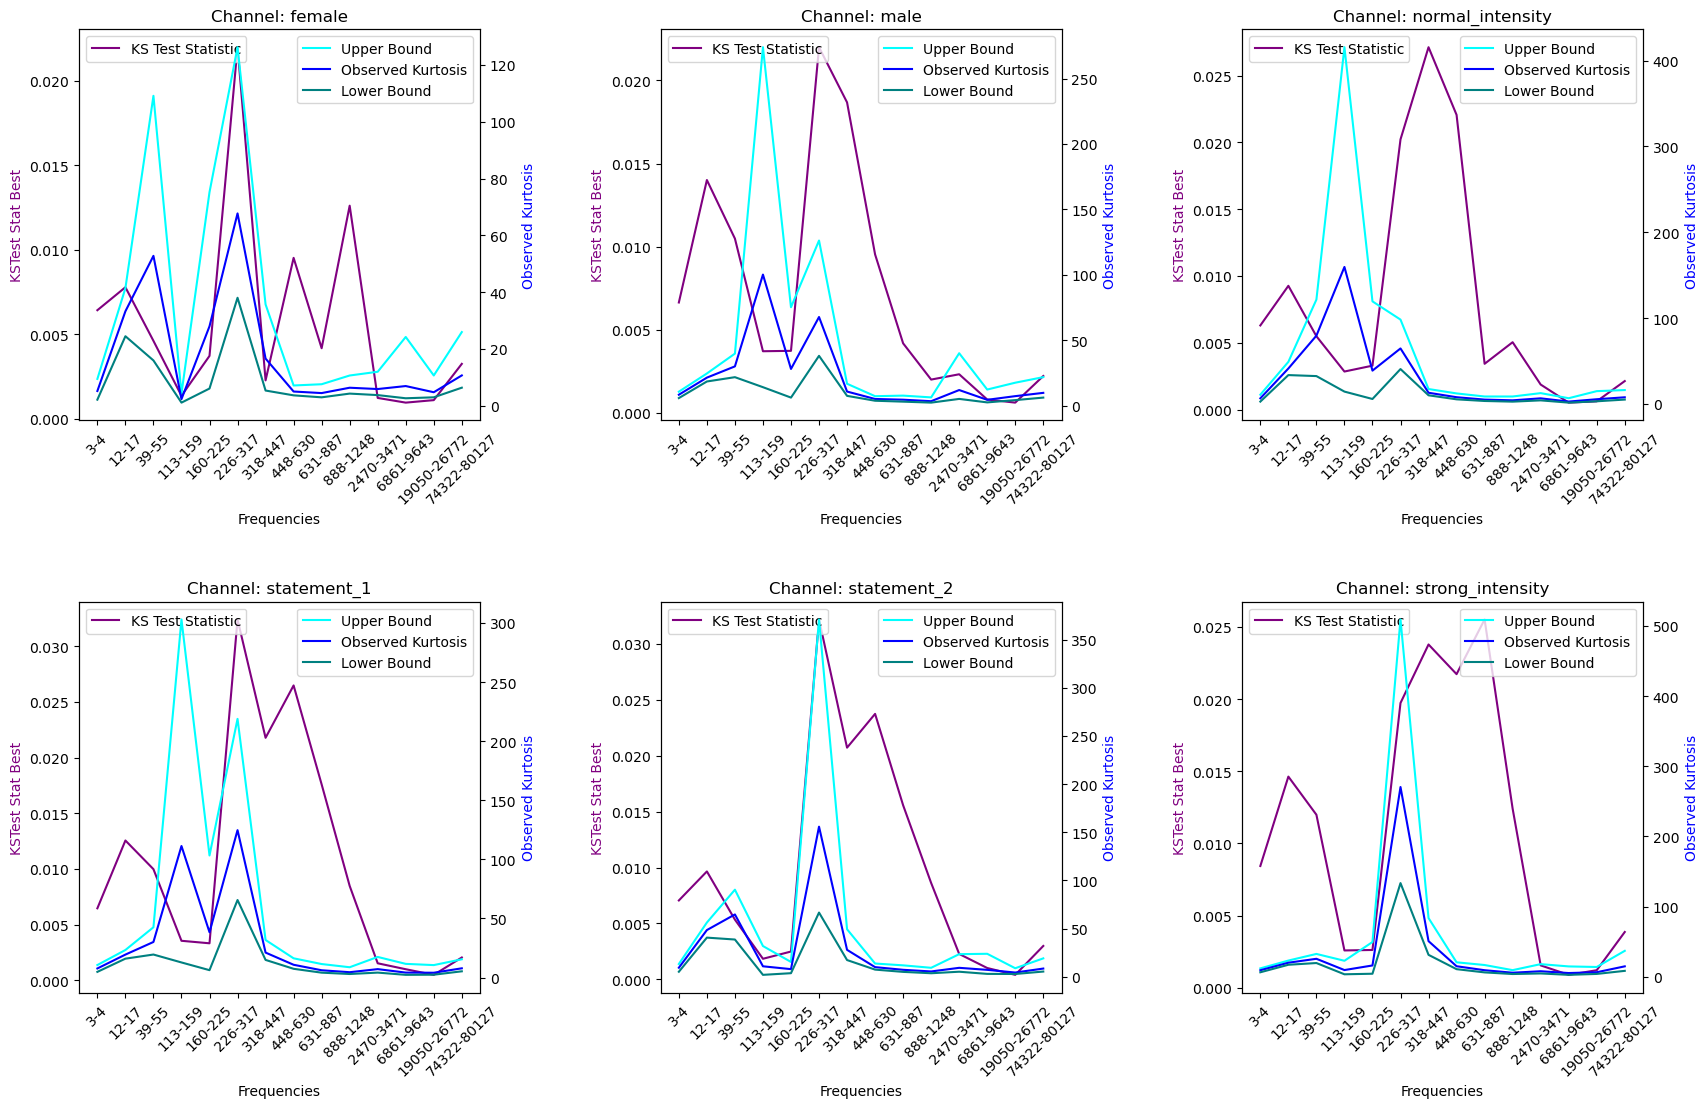

In [70]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (18, 12))

fft_geocomp = fft[fft['subset'] == '1e5geocomp']
counter = 0
for group in GROUPS['ravdess']:
    subset = fft_geocomp[fft_geocomp['channel'] == group]
    freqs = subset['frequencies']
    def sort_key(val):
        part = str(val).split('-')[0]
        try:
            return int(part)
        except ValueError:
            return float('inf')

    sorted_indices = freqs.apply(sort_key).sort_values().index
    axs[counter // 3, counter % 3].plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kstest_stat_best'], label = 'KS Test Statistic', color = 'purple')
    axs[counter // 3, counter % 3].set_title(f'Channel: {group}')
    axs[counter // 3, counter % 3].set_xlabel('Frequencies')
    axs[counter // 3, counter % 3].set_ylabel('KSTest Stat Best', color = 'purple')
    axs[counter // 3, counter % 3].tick_params(axis = 'x', labelrotation = 45)
    ax2 = axs[counter // 3, counter % 3].twinx()
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kurt_upper'], label = 'Upper Bound', color = 'cyan')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'obs_kurt'], label = 'Observed Kurtosis', color = 'blue')
    ax2.plot(subset.loc[sorted_indices, 'frequencies'], subset.loc[sorted_indices, 'kurt_lower'], label = 'Lower Bound', color = 'teal')
    ax2.set_xlabel('Frequencies')
    ax2.set_ylabel('Observed Kurtosis', color = 'blue')
    ax2.tick_params(axis = 'x', labelrotation = 45)
    ax2.legend(loc = 'upper right')
    axs[counter // 3, counter % 3].legend(loc = 'upper left')
    counter += 1

fig.tight_layout(pad=4.0) 

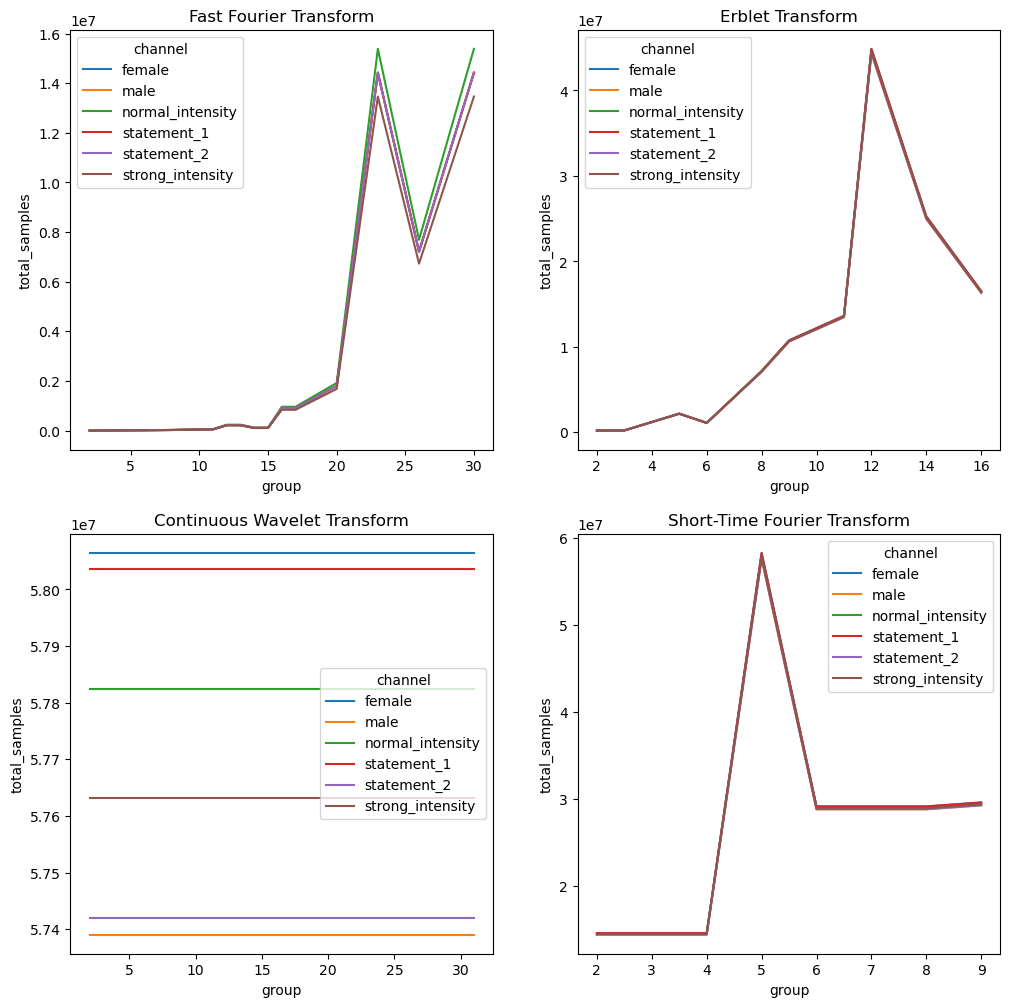

In [15]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 12))

fft_rawcomp = fft[fft['subset'] == '1e5rawcomp']
erb_rawcomp = erb[erb['subset'] == '1e5rawcomp']
cwt_rawcomp = cwt[cwt['subset'] == '1e5rawcomp']
stft_rawcomp = stft[stft['subset'] == '1e5rawcomp']

sns.lineplot(data = fft_rawcomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[0,0]);
axs[0,0].set_title('Fast Fourier Transform');
sns.lineplot(data = erb_rawcomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[0,1]);
axs[0,1].set_title('Erblet Transform');
sns.lineplot(data = cwt_rawcomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[1,0]);
axs[1,0].set_title('Continuous Wavelet Transform');
sns.lineplot(data = stft_rawcomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[1,1]);
axs[1,1].set_title('Short-Time Fourier Transform');


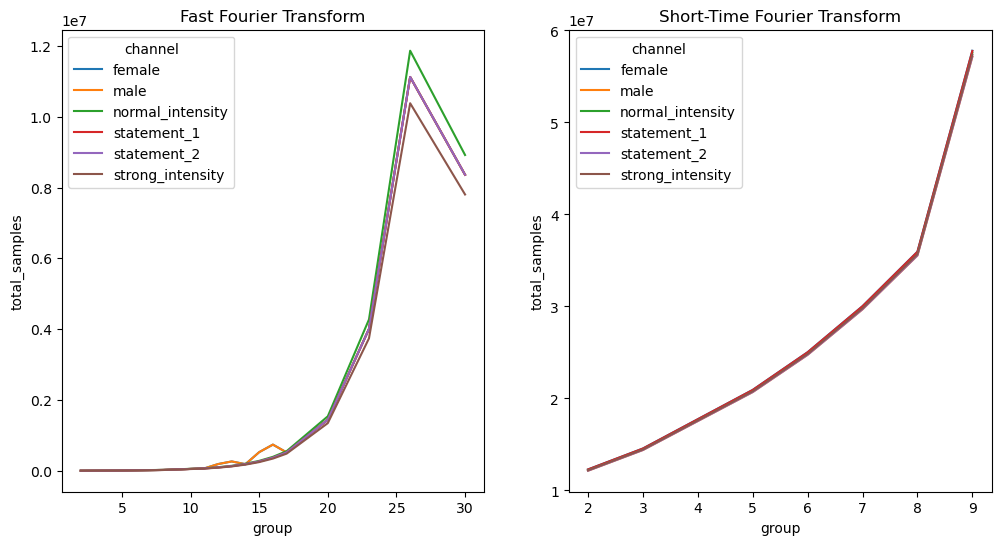

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))

fft_geocomp = fft[fft['subset'] == '1e5geocomp']
stft_geocomp = stft[stft['subset'] == '1e5geocomp']

sns.lineplot(data = fft_geocomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[0]);
axs[0].set_title('Fast Fourier Transform');
sns.lineplot(data = stft_geocomp, x = 'group', y = 'total_samples', hue = 'channel', errorbar = None, ax = axs[1]);
axs[1].set_title('Short-Time Fourier Transform');
